In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as lm

In [116]:
df = pd.read_stata('ps1-data-1.dta')

C:\Users\nicco\AppData\Local\Temp\ipykernel_43944\2661949827.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata('ps1-data-1.dta')


In [117]:
df_clean = df[['y', 'dem', 'wbcode2', 'year']].dropna()

country_dummies = pd.get_dummies(df_clean['wbcode2'], prefix='country', drop_first=False).values
year_dummies = pd.get_dummies(df_clean['year'], prefix='year', drop_first=False).values

X = np.zeros((df_clean.shape[0], 1 + len(country_dummies[0]) + len(year_dummies[0])))

X[:, 0] = df_clean['dem'].values
X[:, 1:1+len(country_dummies[0])] = country_dummies
X[:, 1+len(country_dummies[0]):] = year_dummies
X[:, -1] = np.zeros(df_clean.shape[0])

y = np.array(df_clean['y'].values)

model = sm.OLS(y, X, missing='drop').fit()

dem_coef = model.params[0]
dem_se = model.bse[0]
dem_tstat = model.tvalues[0]
dem_pval = model.pvalues[0]

print('Model 1')
print('D_ct coefficient: {:.4f}'.format(dem_coef))
print('D_ct standard error: {:.4f}'.format(dem_se))
print('D_ct t-statistic: {:.4f}'.format(dem_tstat))
print('D_ct p-value: {:.4f}'.format(dem_pval))

Model 1
D_ct coefficient: -10.1122
D_ct standard error: 1.1459
D_ct t-statistic: -8.8250
D_ct p-value: 0.0000


In [118]:
df_2 = df_clean.copy()

df_2['y_diff'] = df_2['y'].diff()

df_clean_2 = df_2.dropna()

country_dummies_2 = pd.get_dummies(df_clean_2['wbcode2'], prefix='country', drop_first=False).values
year_dummies_2 = pd.get_dummies(df_clean_2['year'], prefix='year', drop_first=False).values

X_2 = np.zeros((df_clean_2.shape[0], 1 + len(country_dummies_2[0]) + len(year_dummies_2[0])))

X_2[:, 0] = df_clean_2['dem'].values
X_2[:, 1:1+len(country_dummies_2[0])] = country_dummies_2
X_2[:, 1+len(country_dummies_2[0]):] = year_dummies_2
X_2[:, -1] = np.zeros(df_clean_2.shape[0])

y_2 = np.array(df_clean_2['y_diff'].values)

model_2 = sm.OLS(y_2, X_2, missing='drop').fit()

dem_coef_2 = model_2.params[0]
dem_se_2 = model_2.bse[0]
dem_tstat_2 = model_2.tvalues[0]
dem_pval_2 = model_2.pvalues[0]

print('\nModel 2')
print('D_ct coefficient: {:.4f}'.format(dem_coef_2))
print('D_ct standard error: {:.4f}'.format(dem_se_2))
print('D_ct t-statistic: {:.4f}'.format(dem_tstat_2))
print('D_ct p-value: {:.4f}'.format(dem_pval_2))


Model 2
D_ct coefficient: 2.0412
D_ct standard error: 1.3816
D_ct t-statistic: 1.4774
D_ct p-value: 0.1396


In [119]:
df_3 = df_clean_2.copy()

lags = 3

for i in range(1, lags+1):
    df_3[f'y_diff_lag{i}'] = df_3['y_diff'].shift(i)

df_clean_3 = df_3.dropna()

country_dummies = pd.get_dummies(df_clean_3['wbcode2'], prefix='country', drop_first=False).values
year_dummies = pd.get_dummies(df_clean_3['year'], prefix='year', drop_first=True).values

X = np.zeros((df_clean_3.shape[0], 1 + lags + len(country_dummies[0]) + len(year_dummies[0])))

X[:, 0] = df_clean_3['dem'].values
for i in range(0, lags):
    X[:, 1+i] = df_clean_3[f'y_diff_lag{i+1}'].values
X[:, 1+lags:1+lags+len(country_dummies[0])] = country_dummies
X[:, 1+lags+len(country_dummies[0]):] = year_dummies
X[:, -1] = np.zeros(df_clean_3.shape[0])

y = np.array(df_clean_3['y_diff'].values)

model = sm.OLS(y, X, missing='drop').fit()

dem_coef = model.params[0]
dem_tstat = model.tvalues[0]

lags_coefs = model.params[1:1+lags]
lags_tstats = model.tvalues[1:1+lags]

print('Democracy coefficient: {:.4f}'.format(dem_coef))
print('Democracy t-statistic: {:.4f}'.format(dem_tstat))

print('\nLag coefficients: {}'.format(lags_coefs))
print('Lag t-statistics: {}'.format(lags_tstats))


Democracy coefficient: 4.1741
Democracy t-statistic: 2.9767

Lag coefficients: [-0.03513198 -0.0254192  -0.02776106]
Lag t-statistics: [-2.82483429 -2.04600393 -2.23551898]


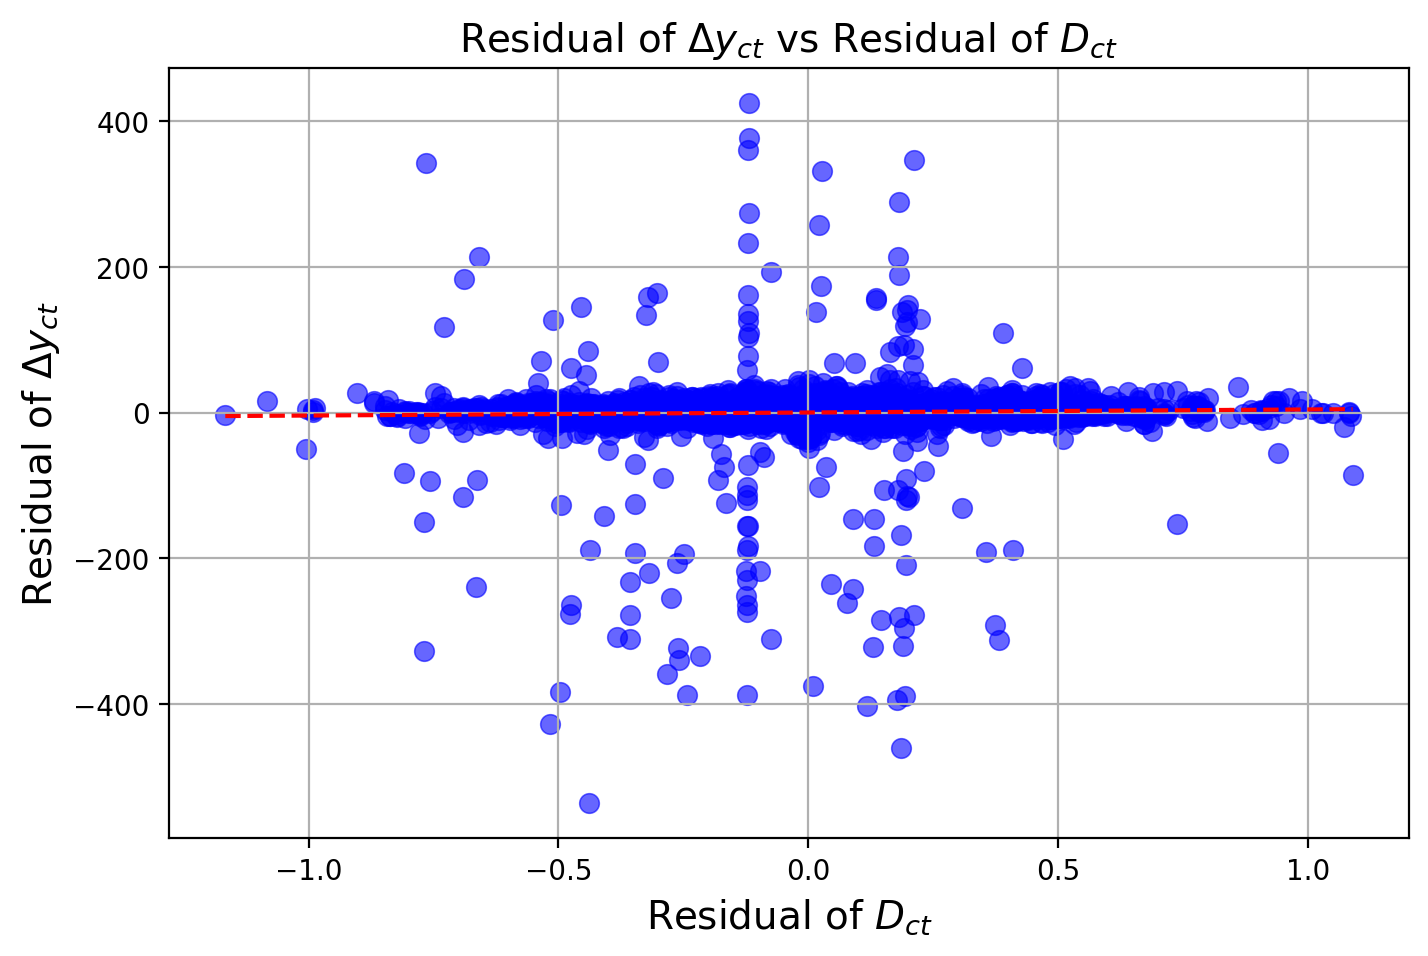

Correlation: 0.03633733496254582667761567904562980402261018753052
T-statistic: 3.02652261129331812128384626703336834907531738281250
P-value: 0.0025


In [120]:
# Step 1: Regress y_diff on control variables (without democracy) to get residuals for y_diff
X_y_diff = X[:, 1:]  # Use the same controls but exclude democracy (already in X)
model_y_diff = sm.OLS(y, X_y_diff, missing='drop').fit()
residual_y_diff = model_y_diff.resid

# Step 2: Regress democracy on control variables (without y_diff) to get residuals for dem
y_dem = df_clean_3['dem'].values
model_dem = sm.OLS(y_dem, X_y_diff, missing='drop').fit()
residual_dem = model_dem.resid

# Step 3: Plot residuals of y_diff vs residuals of democracy
plt.figure(figsize=(8, 5), dpi=200)
sns.scatterplot(x=residual_dem, y=residual_y_diff, s=50, color='blue', alpha=0.6, edgecolor=None)

# Fit line
z = np.polyfit(residual_dem, residual_y_diff, 1)
p = np.poly1d(z)
sns.lineplot(x=residual_dem, y=p(residual_dem), color='red', linestyle='--')

plt.xlabel(r'Residual of $D_{ct}$', fontsize=14)
plt.ylabel(r'Residual of $\Delta y_{ct}$', fontsize=14)
plt.title(r'Residual of $\Delta y_{ct}$ vs Residual of $D_{ct}$', fontsize=14)
plt.grid(True)
plt.show()

# Step 4: Calculate correlation and significance test
correlation = np.corrcoef(residual_dem, residual_y_diff)[0, 1]
print(f'Correlation: {correlation:.50f}')

# t-test
n = len(residual_dem)
t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=n-2))

print(f'T-statistic: {t_stat:.50f}')
print(f'P-value: {p_value:.4f}')

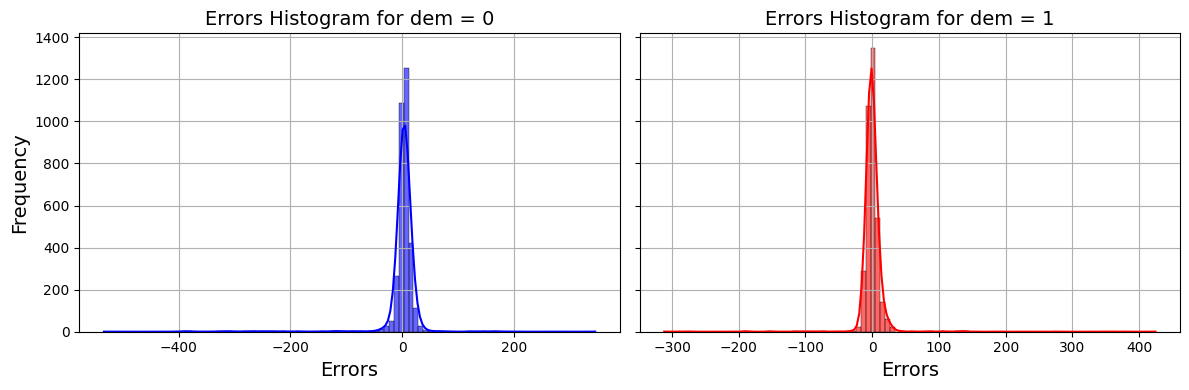

In [75]:
# plot errors histogram for dem = 0 and dem = 1 separately in two subplots

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.histplot(errors[df_clean_3['dem'] == 0], color='blue', alpha=0.6, bins=100, kde=True, ax=axes[0])
axes[0].set_title('Errors Histogram for dem = 0', fontsize=14)
axes[0].set_xlabel('Errors', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].grid(True)

sns.histplot(errors[df_clean_3['dem'] == 1], color='red', alpha=0.6, bins=100, kde=True, ax=axes[1])
axes[1].set_title('Errors Histogram for dem = 1', fontsize=14)
axes[1].set_xlabel('Errors', fontsize=14)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Check exogeneity of democracy in model 3 by plotting errors against democracy
import scipy.stats as stats

y_diff_pred = model.predict(X)

errors = y - y_diff_pred

plt.figure(figsize=(8, 4))

sns.scatterplot(x=df_clean_3['dem'], y=errors, s=50, color='blue', alpha=0.6, edgecolor=None)
sns.lineplot(x=df_clean_3['dem'], y=p(df_clean_3['dem']), color='red', linestyle='--')

plt.xlabel('Democracy', fontsize=14)
plt.ylabel('Errors', fontsize=14)
plt.title('Democracy vs Errors', fontsize=14)
plt.grid(True)

plt.show()

# Calculate correlation
correlation = np.corrcoef(df_clean_3['dem'], errors)[0, 1]
print(f'Correlation: {correlation:.50f}')

# Test significance with t-test
n = len(df_clean_3['dem'])
t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=n-2))

print(f'T-statistic: {t_stat:.50f}')
print(f'P-value: {p_value:.4f}')
